In [1]:
%reload_ext autoreload
%autoreload 2

<center><h1>Graph Convolution Network using PyTorch Geometric</h1></center>

<div style="background-color:rgba(192,192,192,0.3); padding:10px 0; font-size:110%; color:black;">
Low-dimensional vector embeddings of nodes in large graphs have numerous applications in machine learning (e.g., node classification, clustering, link prediction).
</div>

$$\large \mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \square_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right),$$

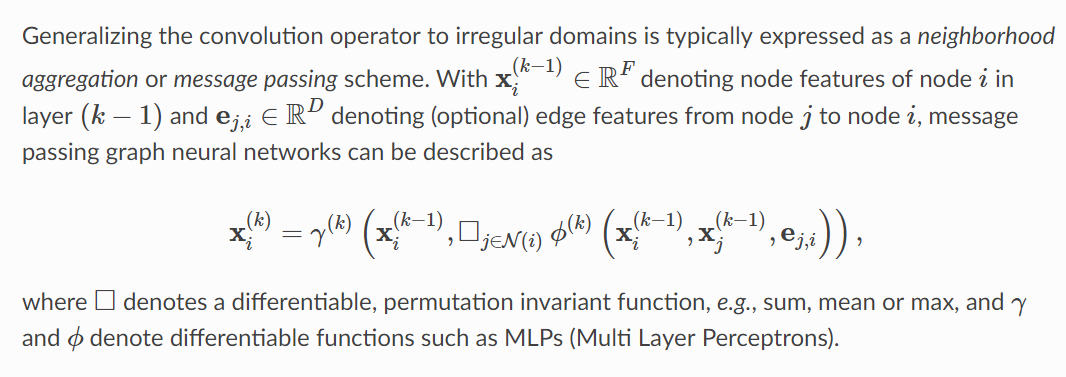

<h3><a href="https://arxiv.org/abs/1609.02907">The graph convolutional operator from the "Semi-supervised Classification with Graph Convolutional Networks"</a><h3>

<div style="background-color:rgba(192,192,192,0.3); padding:10px 0; font-size:110%; color:black;">
The Kipf and Welling paper describes the Graph Convolution operation as:
</div>

$$H^{(l+1)} = \sigma\left(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)$$

$\tilde{A} = A+I_{N}\text{ is the adjacency matrix of the undirected graph G with added self-connections.}$<br>
$I_{N}\text{ is the identity matrix.}$<br>
$\tilde{D}_{ii}=\Sigma_{j}\tilde{A}_{ij}\text{ is the degree matrix.}$<br>
$W^{(l)}\text{ is a layer-specific trainable weight matrix.}$<br>
$\sigma\text{ denotes the activation function}$<br>
$H^{(l)}\in\mathbb{R}^{N\times D}\text{ is the matrix of activations in the $l^{th}$ layer; $H^{(0)}=X$}$

<div style="background-color:rgba(192,192,192,0.3); padding:10px 0; font-size:110%; color:black;">
The above can be rearranged as:
</div>

$$\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta} \cdot \mathbf{x}_j^{(k-1)} \right)$$<br>$\mathbf{\Theta}\text{ is the weight matrix by which the neighboring nodes are transformed.}$<br>$\mathcal{N}(i)\text{ are the Neighborhood nodes of node }\mathcal{i}.$<br>$\mathbf{x}_j^{(k-1)}\text{ is the feature of node }\mathcal{j}\text{ at layer }\mathcal{(k-1)}.$<br>$\mathbf{deg(i)}\text{ gives the degree of node }\mathcal{i}\text{.}$

<div style="background-color:rgba(192,192,192,0.3); padding:10px 0; font-size:110%; color:black">
The operation can be broken down into the following steps:
<ol>
    <li> Add self-loops to the Adjacency matrix.
    <li> Compute normalization coefficients.
    <li> Linearly transform node feature matrix.
    <li> Normalize node features in ϕ.
    <li> Sum up neighboring node features (if "add" aggregation).
</ol>
</div>

<h3>A Graph network</h3>

In [2]:
import torch
from torch_geometric.data import Data

In [3]:
#define property of the nodes or node features
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)

In [4]:
#define edges between the nodes
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [5]:
#define the property of edges
edge_attr = torch.tensor([4,10,3,1,5],dtype=torch.float)

In [6]:
#define the classes the nodes belong to
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

<div style="background-color:rgba(192,192,192,0.3); padding:1px 0; font-size:105%; color:black">
<p>With these defined, the PyTorch Geometric's <b>Data</b> object now can be initialized</p>
</div>

In [7]:
g = Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y)

<center><img src="tmp/viz_objects/1.png" alt="Input" width="500"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Step 1:</h4>
<p>Add self-loops to the Adjacency matrix.</p>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>This step is required to aggregate the node's own feature with the features of its neighboring nodes:</p>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>Before:</p>
</div>

In [8]:
g.edge_index

tensor([[0, 1, 2, 0, 3],
        [1, 0, 1, 3, 2]])

In [9]:
g.edge_attr

tensor([ 4., 10.,  3.,  1.,  5.])

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>After:</p>
</div>

In [10]:
from torch_geometric.utils import add_remaining_self_loops

In [11]:
new_edge_index, new_edge_attr = add_remaining_self_loops(
            edge_index, edge_attr, fill_value=1., num_nodes=4)

In [12]:
new_edge_index

tensor([[0, 1, 2, 0, 3, 0, 1, 2, 3],
        [1, 0, 1, 3, 2, 0, 1, 2, 3]])

In [13]:
new_edge_attr

tensor([ 4., 10.,  3.,  1.,  5.,  1.,  1.,  1.,  1.])

<center><img src="tmp/viz_objects/2.png" alt="Add-Self-Loop" width="700"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Step 2:</h4>
<p>Compute normalization coefficients.</p>
</div>

In [14]:
from torch_scatter import scatter_add

In [15]:
#compute the degree of each node (Sum of weights in edges incoming towards a node)
row, col = new_edge_index[0], new_edge_index[1]
deg = scatter_add(new_edge_attr, col, dim=0, dim_size=4)#dim_size = num_nodes
#Compute the normalization coefficients
deg_inv_sqrt = deg.pow_(-0.5)
deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
normalized_coefficients = deg_inv_sqrt[row] * new_edge_attr * deg_inv_sqrt[col]

In [16]:
normalized_coefficients

tensor([0.4264, 1.0660, 0.4330, 0.2132, 1.4434, 0.0909, 0.1250, 0.1667, 0.5000])

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>Normalizing:</p>
</div>

<center><img src="tmp/viz_objects/3.png" alt="Normalize" width="700"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>After normalizing:</p>
</div>

<center><img src="tmp/viz_objects/3_simplify.png" alt="Simplify" width="700"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Step 3:</h4>
<p>Linearly transform node feature matrix.</p>
</div>

In [47]:
from torch.nn import Parameter
from torch_geometric.nn.inits import glorot, zeros

In [130]:
in_channels = 2
out_channels = 2 # for vizualization purpose, we are setting it to 2

In [131]:
torch.manual_seed(42)
weight = Parameter(torch.Tensor(in_channels, out_channels))
bias = Parameter(torch.Tensor(out_channels))
glorot(weight)
zeros(bias)

In [143]:
x = torch.matmul(g.x, weight)

In [144]:
x

tensor([[ 1.5858,  3.1582],
        [ 2.9603, 11.8331],
        [ 0.8006, 10.9251],
        [11.2364, 12.1986]], grad_fn=<MmBackward>)

<center><img src="tmp/viz_objects/4_new.png" alt="Convolve" width="700"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Step 4:</h4>
<p>Normalize node features in ϕ.</p>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>Preparing the linearly transformed node features.</p>
</div>

In [147]:
x = x.index_select(-2, new_edge_index[0])

In [148]:
x

tensor([[ 1.5858,  3.1582],
        [ 2.9603, 11.8331],
        [ 0.8006, 10.9251],
        [ 1.5858,  3.1582],
        [11.2364, 12.1986],
        [ 1.5858,  3.1582],
        [ 2.9603, 11.8331],
        [ 0.8006, 10.9251],
        [11.2364, 12.1986]], grad_fn=<IndexSelectBackward>)

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>Preparing the normalization coefficients.</p>
</div>

In [150]:
normalized_coefficients = normalized_coefficients.view(-1, 1)

In [151]:
normalized_coefficients

tensor([[0.4264],
        [1.0660],
        [0.4330],
        [0.2132],
        [1.4434],
        [0.0909],
        [0.1250],
        [0.1667],
        [0.5000]])

In [153]:
normalized_node_features = normalized_coefficients * x

In [154]:
normalized_node_features

tensor([[ 0.6762,  1.3466],
        [ 3.1557, 12.6142],
        [ 0.3467,  4.7307],
        [ 0.3381,  0.6733],
        [16.2183, 17.6071],
        [ 0.1442,  0.2871],
        [ 0.3700,  1.4791],
        [ 0.1334,  1.8208],
        [ 5.6182,  6.0993]], grad_fn=<MulBackward0>)

$$\begin{pmatrix}
     1.5858 &  3.1582 \\
     2.9603 & 11.8331 \\
     0.8006 & 10.9251 \\
     1.5858 &  3.1582 \\
    11.2364 & 12.1986 \\
     1.5858 &  3.1582 \\
     2.9603 & 11.8331 \\
     0.8006 & 10.9251 \\
    11.2364 & 12.1986 \\
    \end{pmatrix}
    \bullet
 \begin{pmatrix}
 0.4264\\
 1.0660\\
 0.4330\\
 0.2132\\
 1.4434\\
 0.0909\\
 0.1250\\
 0.1667\\
 0.5000\\
\end{pmatrix}
=
\begin{pmatrix}
0.6762 &  1.3466\\
3.1557 & 12.6142\\
0.3467 &  4.7307\\
0.3381 &  0.6733\\
16.2183 & 17.6071\\
0.1442 &  0.2871\\
0.3700 &  1.4791\\
0.1334 &  1.8208\\
5.6182 &  6.0993\\
\end{pmatrix}$$

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Step 5:</h4>
<p>Sum up neighboring node features (if <b>"add"</b> aggregation).</p>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<p>Other techniques can also be used for aggregation:
<ul>
<li> Summation
<li> Average
<li> Max
</ul>
</p>
</div>

In [157]:
from torch_scatter import scatter

In [164]:
new_edge_index

tensor([[0, 1, 2, 0, 3, 0, 1, 2, 3],
        [1, 0, 1, 3, 2, 0, 1, 2, 3]])

In [173]:
new_x = scatter(normalized_node_features, index=new_edge_index[1], dim=-2, dim_size=4,
                           reduce="add")

In [174]:
new_x

tensor([[ 3.2998, 12.9013],
        [ 1.3929,  7.5565],
        [16.3517, 19.4280],
        [ 5.9563,  6.7726]], grad_fn=<ScatterAddBackward>)

<center><img src="tmp/viz_objects/5.png" alt="Updated" style="width: 700px;"/></center>

<h3><a href="https://arxiv.org/pdf/1706.02216.pdf">The GraphSAGE operator from the "Inductive Representation Learning on Large Graphs"</a><h3>

<center><img src="tmp/viz_objects/gsage2.png" alt="Updated" style="width: 700px;"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4>Motivation:</h4>
<ul><li>Most embedding frameworks (during the publication of this paper) are inherently <b>transductive</b> and can only generate embeddings for a single fixed graph. These transductive approaches do not efficiently generalize to unseen nodes (e.g., in evolving graphs), and these approaches cannot learn to generalize across different graphs.
    <li>In contrast, GraphSAGE is an <b>inductive</b> framework that leverages node attribute information to efficiently generate representations on previously unseen data. To run GraphSAGE, it needs to train on an example graph or set of graphs. After training, GraphSAGE can be used to generate node embeddings for previously unseen nodes or entirely new input graphs, as long as these graphs have the same attribute schema as the training data.
    </ul>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
The original <a href = "https://arxiv.org/abs/1609.02907">GCN algorithm</a> (discussed above) is designed for semi-supervised learning in a <b>transductive</b> setting, and the exact algorithm requires additional information that the full graph Laplacian is known during
training.<br>
    $$L=D-A$$
 <ul>
    <li>$\text{L is the graph Laplacian}$
    <li>$\text{D is the Degree matrix}$
    <li>$\text{A is the Adjacency matrix}$
  </ul>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Algorithm</h4>
</div>

<center><img src="tmp/viz_objects/gsage1.png" alt="Updated" style="width: 700px;"/></center>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Aggregator Functions:</h4>
<p>Ideally, an aggregator function would be <b>symmetric</b> (i.e., invariant to permutations of its inputs) while still being <b>trainable and maintaining high representational capacity</b>.
The symmetry property of the aggregation function ensures that our neural network model can be trained and applied to arbitrarily ordered node neighborhood feature set.</p>
    <ul>
        <li> <b>Mean</b> $$\mathbf{h}_{v}^{k}\leftarrow\sigma\left(\mathbf{W}\cdot\textrm{MEAN}\left(\{\mathbf{h}_{v}^{k-1}\}\cup\{\mathbf{h}_{u}^{k-1},\forall u\in\mathcal{N}(v)\}\right)\right)$$
        <li> <b>Pooling</b> $$\textrm{AGGREGATE}_{k}^{\textrm{pool}}\leftarrow\max\left(\{\sigma\left(\mathbf{W}_{\textrm{pool}}\mathbf{h}_{u_i}^{k}+\mathbf{b}\right),\forall u_i\in\mathcal{N}(v)\}\right)$$
        <li> <b>LSTM</b>$$\textrm{AGGREGATE}_{k}^{\textrm{LSTM}}\leftarrow\textrm{LSTM}\left([\textbf{h}_{u}^{k-1},\forall u\in\pi\left(\mathcal{N}(v)\right)]\right)$$ $$\pi\text{ indicates some random permuations of neighbors}$$
    </ul>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4>Incorporating weights in edges:</h4>
<ul><li>Trivial method like weighted mean aggregation<li>Using Attention network</ul>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h5>Attention mechanism:</h5>
    <ul>
    <li>Let $\large a$ compute <b>attention coefficients</b> $\large e_{vu}$ across pair of nodes $\large u,v$ based on their messages:</li>
        $$\large e_{vu}=a\left(\mathbf{W}_k\mathbf{h}_{u}^{k-1},\mathbf{W}_k\mathbf{h}_{v}^{k-1}\right)$$
            $\large e_{vu}$ indicates the importance of node $\large u's$ message to node $\large v$
    <li>Normalize coefficients using the softmax function in order to be comparable across different neighborhoods:</li>
        $$\large \alpha_{vu}=\frac{\text{exp}(e_{vu})}{\Sigma_{k \in N(v)}\text{exp}(e_{vk})}$$
    <li>Compute activation using:</li>
        $$\large h_{v}^{k}=\sigma\left(\Sigma_{u \in N(v)}\alpha_{vu}\mathbf{W}_{k}\mathbf{h}_{u}^{k-1}\right)$$
    </ul>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
<h4> Loss Function</h4>
</div>

<div style="background-color:rgba(192,192,192,0.3); font-size:105%; color:black">
In order to learn useful, predictive representations in a fully unsupervised setting, we apply a
graph-based loss function to the output representations, $z_u, \forall u \in \mathcal{V}$, and tune the weight matrices,
$\mathbf{W}_k, \forall k \in \{1, ..., K\},$ and parameters of the aggregator functions via stochastic gradient descent. The
graph-based loss function encourages nearby nodes to have similar representations, while enforcing
that the representations of disparate nodes are highly distinct:
$$\large J_{\mathcal{G}}\left(\mathbf{z}_{u}\right)=-\text{log}\left(\sigma\left(\mathbf{z}_{u}^{\text{T}}\mathbf{z}_{v}\right)\right) - Q\cdot\mathbb{E}_{v_{n}\sim P_n(v)}\text{log}\left(\sigma\left(-\mathbf{z}_{u}^{\text{T}}\mathbf{z}_{v_{n}}\right)\right)$$
where $v$ is a node that co-occurs near $u$ on fixed-length random walk, $\sigma$ is the sigmoid function,
$P_n$ is a negative sampling distribution, and $Q$ defines the number of negative samples. Importantly,
unlike previous embedding approaches, the representations $\textbf{z}_u$ that we feed into this loss function
are generated from the features contained within a node’s local neighborhood, rather than training a
unique embedding for each node (via an embedding look-up).
</div>

<h3>A Graph network</h3>

In [1]:
import torch
from torch_geometric.data import Data

In [2]:
#define property of the nodes or node features
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)

In [3]:
#define edges between the nodes
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [4]:
#define the classes the nodes belong to
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

<div style="background-color:rgba(192,192,192,0.3); padding:1px 0; font-size:105%; color:black">
<p>Intializing the PyTorch Geometric's <b>Data</b> object</p>
</div>

In [6]:
g = Data(x=x,edge_index=edge_index,y=y)

In [7]:
g

Data(edge_index=[2, 5], x=[4, 2], y=[4])